# Predicting House Sale Prices

In this project I will be exploring ways to imporve machine learning models for predictive analysis.  I will be working with housing data for the city of Ames, Iowa, United Stataes from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#reading the data set
housing = pd.read_csv('AmesHousing.tsv',sep='\t')

In [3]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Feature Engineering

Handle missing values:
- All columns:
    - Drop any with 5% or more missing values for now.
- Text columns:
    - Drop any with 1 or more missing values for now.
- Numerical columns:
    - For columns with missing values, fill in with the most common value in that column
    
    
Workflow:
- remove features with high percentage of missing values
- drop or review variables that have very low variation
- many variables are often correlated with eachother and hence are redundant
- drop variables with very low correlation with target


In [4]:
def transform_features(df):
    five_pct = df.shape[0]*.05
    train_nulls = housing.isnull().sum().sort_values()
    drop_train = train_nulls[train_nulls>five_pct]
    test_cpy = df.drop(drop_train.index, axis=1)
    test_cpy = test_cpy.fillna(test_cpy.mean())
    #Adding potentially useful column that shows how many years passed before home was recorded
    test_cpy['years_until_remod'] = test_cpy['Year Remod/Add']-test_cpy['Year Built']

    #Removing all non numerical values which have more than one missing value
    txt_cnt = test_cpy.select_dtypes(['object']).isnull().sum().sort_values(ascending=False)
    drop_txt = txt_cnt[txt_cnt > 0]
    test_cpy = test_cpy.drop(drop_txt.index,axis=1)
    
    #Creating a new column showing the number of years the house was sold
    test_cpy['years_sold'] = test_cpy['Yr Sold'] - test_cpy['Year Built']
    test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]
    
    #dropping negative values in the years_sold and years_until remod columns
    test_cpy = test_cpy.drop([test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]])
    test_cpy[test_cpy['years_until_remod'] < 0]['years_until_remod']
    test_cpy = test_cpy.drop([850])
    
    #Removing the Year Built and Year Remod/Add columns because they are no longer necessary
    test_cpy = test_cpy.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #Removing other unnecessary columns
    
    drop_cols = ['PID','Mo Sold',"Sale Condition", "Sale Type"]
    test_cpy = test_cpy.drop(drop_cols,axis=1)
    
    return test_cpy
    
def select_features(df):
    new_df = df[["Gr Liv Area","SalePrice"]]
    return new_df

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    #train model using all numerical columns except SalePrice (target)
    lr = LinearRegression()
    lr.fit(train.drop(['SalePrice'],axis=1),train['SalePrice'])
    prediction = lr.predict(test.drop(['SalePrice'],axis=1))
    mse = mean_squared_error(y_true=test['SalePrice'],y_pred=prediction)
    rmse = np.sqrt(mse)
    return rmse,lr.score(train.drop(['SalePrice'],axis=1),train['SalePrice'])
    
    

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
selected = select_features(transform_df)
rmse,score = train_and_test(selected)
print('rmse= {0},r^2={1}'.format(rmse, score))
    

rmse= 56072.52569017749,r^2=0.48896832666407086


0.5082164631681965

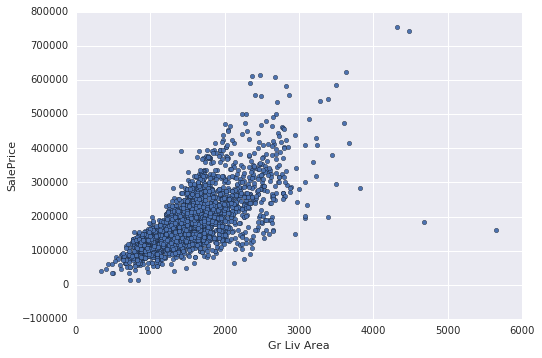

In [5]:
selected.plot.scatter(x='Gr Liv Area',y='SalePrice')
lr_test = LinearRegression().fit(selected[['Gr Liv Area']],selected['SalePrice'])
lr_test.score(selected[['Gr Liv Area']],selected['SalePrice'])

In [6]:
five_pct = housing.shape[0]*.05
train_nulls = housing.isnull().sum().sort_values()
drop_train = train_nulls[train_nulls>five_pct]
test_cpy = housing.drop(drop_train.index, axis=1)
test_cpy = test_cpy.fillna(test_cpy.mean())
#Adding potentially useful column that shows how many years passed before home was recorded
test_cpy['years_until_remod'] = test_cpy['Year Remod/Add']-test_cpy['Year Built']

In [7]:
#Removing all non numerical values which have more than one missing value
txt_cnt = test_cpy.select_dtypes(['object']).isnull().sum().sort_values(ascending=False)
drop_txt = txt_cnt[txt_cnt > 0]
test_cpy = test_cpy.drop(drop_txt.index,axis=1)

In [8]:
test_cpy.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_until_remod
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000,0
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000,0
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000,0
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000,0
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900,1


In [9]:
cnt_var = test_cpy.select_dtypes(['number']).var()
cnt_low = cnt_var[cnt_var < 10]

In [10]:
test_cpy['years_sold'] = test_cpy['Yr Sold'] - test_cpy['Year Built']
test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]

2180

In [11]:
test_cpy = test_cpy.drop([test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]])

In [12]:
test_cpy[test_cpy['years_until_remod'] < 0]['years_until_remod']

850   -1
Name: years_until_remod, dtype: int64

In [13]:
test_cpy = test_cpy.drop([850])

In [14]:
test_cpy = test_cpy.drop(["Year Built", "Year Remod/Add"], axis = 1)

# Feature Selection



In [15]:
transform_df.head()

,Order,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,years_until_remod,years_sold
0,1,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,2.0,528.0,P,210,62,0,0,0,0,0,2010,215000,0,50
1,2,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,2010,105000,0,49
2,3,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,2010,172000,0,52
3,4,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,2.0,522.0,Y,0,0,0,0,0,0,0,2010,244000,0,42
4,5,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,2010,189900,1,13


In [16]:
numerical_df = transform_df.select_dtypes(['number'])
numerical_df.head()

,Order,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,years_until_remod,years_sold
0,1,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,2010,215000,0,50
1,2,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,2010,105000,0,49
2,3,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,2010,172000,0,52
3,4,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,2010,244000,0,42
4,5,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,2010,189900,1,13


In [17]:
corr = numerical_df.corr().SalePrice.sort_values()
high_corr = corr[corr > .4]
low_corr = corr[corr < 0.4]
strong_corr_df = numerical_df[high_corr.index].corr()
#Changing the numeric dataframe
new_numeric_df = numerical_df[strong_corr_df.columns]

In [18]:
low = list(low_corr.index)
#Transformed Dataframe will only contain highly correlated numerical columns
transform_df = transform_df.drop(low,axis=1)
transform_df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,1080.0,GasA,Fa,Y,1656,1656,1,TA,7,Typ,2,2.0,528.0,P,215000
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,882.0,GasA,TA,Y,896,896,1,TA,5,Typ,0,1.0,730.0,Y,105000
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,1329.0,GasA,TA,Y,1329,1329,1,Gd,6,Typ,0,1.0,312.0,Y,172000
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,2110.0,GasA,Ex,Y,2110,2110,2,Ex,8,Typ,2,2.0,522.0,Y,244000
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,928.0,GasA,Gd,Y,928,1629,2,TA,6,Typ,1,2.0,482.0,Y,189900
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,Gable,CompShg,VinylSd,VinylSd,20.0,TA,TA,PConc,602.0,926.0,GasA,Ex,Y,926,1604,2,Gd,7,Typ,1,2.0,470.0,Y,195500
6,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,Gable,CompShg,CemntBd,CmentBd,0.0,Gd,TA,PConc,616.0,1338.0,GasA,Ex,Y,1338,1338,2,Gd,6,Typ,0,2.0,582.0,Y,213500
7,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,Gable,CompShg,HdBoard,HdBoard,0.0,Gd,TA,PConc,263.0,1280.0,GasA,Ex,Y,1280,1280,2,Gd,5,Typ,0,2.0,506.0,Y,191500
8,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,Gable,CompShg,CemntBd,CmentBd,0.0,Gd,TA,PConc,1180.0,1595.0,GasA,Ex,Y,1616,1616,2,Gd,5,Typ,1,2.0,608.0,Y,236500
9,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,0.0,994.0,GasA,Gd,Y,1028,1804,2,Gd,7,Typ,1,2.0,442.0,Y,189000


Below is a heatmap of the most strongly correlated features to the SalePrice column

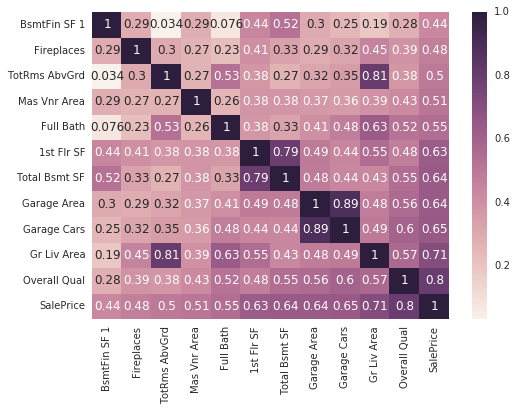

In [19]:
sns.heatmap(strong_corr_df,annot=True)

In the above function 'select_features()' function, I will only choose features with above corr=0.4 to use in my regression equation.

Now we will concider which columns in the data frame should be converted to the categorical data type.  All of the columns that can be categorized as nominal variables are candidates for being converted to categorical.
- Which categorical columns have few unique values?
    - This would be an unworthy feature to use in our calculation because it has low variance
- If a categorical column has hundreds of unique values (or categories) it should not be kept because that is the number of columns that will need to be appended to the dataframe.
- Columns may be numerical but need to be encoded as categorical.

In [20]:
object_type_df = transform_df.select_dtypes(['object'])
unique_val_count = object_type_df.nunique()
# Unique cuttoff is 10 values
drop_unique_count = unique_val_count[unique_val_count > 10]
object_type_df = object_type_df.drop(drop_unique_count.index,axis=1)
#Looking at the value counts of each column
ratio_categories = object_type_df.apply(lambda cols:cols.value_counts(normalize=True))

In [21]:
# Dropping columns with more than 10 categories
transform_df = transform_df.drop(drop_unique_count.index,axis=1)

# Getting columns with low variability
rat_cols = ratio_categories.max() > 0.95
drop_rat = []
for index,val in rat_cols.iteritems():
    if (val):
        drop_rat.append(index)

# Dropping columns with low variability
transform_df = transform_df.drop(drop_rat,axis=1)

In [22]:
transform_df.head()

,MS Zoning,Lot Shape,Land Contour,Lot Config,Condition 1,Bldg Type,House Style,Overall Qual,Roof Style,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice
0,RL,IR1,Lvl,Corner,Norm,1Fam,1Story,6,Hip,112.0,TA,TA,CBlock,639.0,1080.0,Fa,Y,1656,1656,1,TA,7,Typ,2,2.0,528.0,P,215000
1,RH,Reg,Lvl,Inside,Feedr,1Fam,1Story,5,Gable,0.0,TA,TA,CBlock,468.0,882.0,TA,Y,896,896,1,TA,5,Typ,0,1.0,730.0,Y,105000
2,RL,IR1,Lvl,Corner,Norm,1Fam,1Story,6,Hip,108.0,TA,TA,CBlock,923.0,1329.0,TA,Y,1329,1329,1,Gd,6,Typ,0,1.0,312.0,Y,172000
3,RL,Reg,Lvl,Corner,Norm,1Fam,1Story,7,Hip,0.0,Gd,TA,CBlock,1065.0,2110.0,Ex,Y,2110,2110,2,Ex,8,Typ,2,2.0,522.0,Y,244000
4,RL,IR1,Lvl,Inside,Norm,1Fam,2Story,5,Gable,0.0,TA,TA,PConc,791.0,928.0,Gd,Y,928,1629,2,TA,6,Typ,1,2.0,482.0,Y,189900


In [23]:
## Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
## Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

In [24]:
transform_df.head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,528.0,215000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,730.0,105000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,312.0,172000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,522.0,244000,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,482.0,189900,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [30]:
def transform_features(df):
    five_pct = df.shape[0]*.05
    train_nulls = housing.isnull().sum().sort_values()
    drop_train = train_nulls[train_nulls>five_pct]
    test_cpy = df.drop(drop_train.index, axis=1)
    test_cpy = test_cpy.fillna(test_cpy.mean())
    #Adding potentially useful column that shows how many years passed before home was recorded
    test_cpy['years_until_remod'] = test_cpy['Year Remod/Add']-test_cpy['Year Built']

    #Removing all non numerical values which have more than one missing value
    txt_cnt = test_cpy.select_dtypes(['object']).isnull().sum().sort_values(ascending=False)
    drop_txt = txt_cnt[txt_cnt > 0]
    test_cpy = test_cpy.drop(drop_txt.index,axis=1)
    
    #Creating a new column showing the number of years the house was sold
    test_cpy['years_sold'] = test_cpy['Yr Sold'] - test_cpy['Year Built']
    test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]
    
    #dropping negative values in the years_sold and years_until remod columns
    test_cpy = test_cpy.drop([test_cpy[test_cpy['years_sold'] < 0]['years_sold'].index[0]])
    test_cpy[test_cpy['years_until_remod'] < 0]['years_until_remod']
    test_cpy = test_cpy.drop([850])
    
    #Removing the Year Built and Year Remod/Add columns because they are no longer necessary
    test_cpy = test_cpy.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    #Removing other unnecessary columns
    
    drop_cols = ['PID','Mo Sold',"Sale Condition", "Sale Type"]
    test_cpy = test_cpy.drop(drop_cols,axis=1)
    
    return test_cpy
    
def select_features(transform_df):
    
    numerical_df = transform_df.select_dtypes(['number'])
    
    corr = numerical_df.corr().SalePrice.sort_values()
    high_corr = corr[corr > .4]
    low_corr = corr[corr < 0.4]
    strong_corr_df = numerical_df[high_corr.index].corr()
    #Changing the numeric dataframe
    new_numeric_df = numerical_df[strong_corr_df.columns]
    
    low = list(low_corr.index)
    #Transformed Dataframe will only contain highly correlated numerical columns
    transform_df = transform_df.drop(low,axis=1)
    
    object_type_df = transform_df.select_dtypes(['object'])
    unique_val_count = object_type_df.nunique()
    # Unique cuttoff is 10 values
    drop_unique_count = unique_val_count[unique_val_count > 10]
    object_type_df = object_type_df.drop(drop_unique_count.index,axis=1)
    #Looking at the value counts of each column
    ratio_categories = object_type_df.apply(lambda cols:cols.value_counts(normalize=True))
    
    # Dropping columns with more than 10 categories
    transform_df = transform_df.drop(drop_unique_count.index,axis=1)

    # Getting columns with low variability
    rat_cols = ratio_categories.max() > 0.95
    drop_rat = []
    for index,val in rat_cols.iteritems():
        if (val):
            drop_rat.append(index)

    # Dropping columns with low variability
    transform_df = transform_df.drop(drop_rat,axis=1)
    
    ## Select just the remaining text columns and convert to categorical
    text_cols = transform_df.select_dtypes(include=['object'])
    for col in text_cols:
        transform_df[col] = transform_df[col].astype('category')
    
    ## Create dummy columns and add back to the dataframe!
    transform_df = pd.concat([
        transform_df, 
        pd.get_dummies(transform_df.select_dtypes(include=['category']))
    ], axis=1).drop(text_cols,axis=1)
    

    
    
    
    
    return transform_df

def train_and_test(k,data):
    lr = LinearRegression()
    if(k == 0):
        train = data[:1460]
        test = data[1460:]
        #train model using all numerical columns except SalePrice (target)
        
        lr.fit(train.drop(['SalePrice'],axis=1),train['SalePrice'])
        prediction = lr.predict(test.drop(['SalePrice'],axis=1))
        mse = mean_squared_error(y_true=test['SalePrice'],y_pred=prediction)
        rmse = np.sqrt(mse)
        return rmse
    if(k == 1):
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = data.sample(frac=1, )
        train = shuffled_df[:1460]
        test = shuffled_df[1460:]
        
        lr.fit(train.drop(['SalePrice'],axis=1),train['SalePrice'])
        predictions_one = lr.predict(test.drop(['SalePrice'],axis=1))
        
        mse_one = mean_squared_error(y_true=test['SalePrice'],y_pred=predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test.drop(['SalePrice'],axis=1),test['SalePrice'])
        predictions_one = lr.predict(train.drop(['SalePrice'],axis=1))
        
        mse_two = mean_squared_error(y_true=train['SalePrice'],y_pred=predictions_one)
        rmse_two = np.sqrt(mse_two)
        return np.mean([rmse_one,rmse_two])
        
    else:
        rmse_values = []
        kf = KFold(n_splits=k,shuffle=True)
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            #train model using all numerical columns except SalePrice (target)
        
            lr.fit(train.drop(['SalePrice'],axis=1),train['SalePrice'])
            prediction = lr.predict(test.drop(['SalePrice'],axis=1))
            mse = mean_squared_error(y_true=test['SalePrice'],y_pred=prediction)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        return np.mean(rmse_values)
                                          
            
    

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
selected = select_features(transform_df)
rmse = train_and_test(3,selected)
print('rmse= {0}'.format(rmse))
    

rmse= 30936.933413363513
